In [1]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [6]:
# The paths for the training and validation images
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/test_dir/val_dir'
test_path= 'base_dir/test_dir/testing_dir'

#number of images in the training set
num_train_samples = 6009
#number of images in the evaluation set
num_val_samples = 2003
#number of images in every forward/backwards pass
train_batch_size = 10
val_batch_size = 10
#dimensions of the image that will be inputed into the network (224x224)
image_size = 224

# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [3]:

# Set up generators
train_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, #pointing to the path where the data is stored
    target_size=(image_size, image_size), #the target size of the image output
    batch_size=train_batch_size) #size of the batches

valid_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function= \
        keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False)

Found 25587 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [3]:
# Create a MobileNet model
mobile = keras.applications.mobilenet.MobileNet()

# Modify the model
# Choose the 6th layer from the last
x = mobile.layers[-6].output

# Add a dropout and dense layer for predictions
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# Create a new model with the new outputs
model = Model(inputs=mobile.input, outputs=predictions)

# Prevent everything except the last 23 layers from being trained
for layer in model.layers[:-23]:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
# Define Top2 and Top3 Accuracy
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

# Compile the model
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [6]:
filepath = "skin_lesion_model.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=valid_batches,
                              validation_steps=val_steps,
                              epochs=5,
                              verbose=1,
                              callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
601/601 [==============================] - 1857s 3s/step - loss: 1.9317 - categorical_accuracy: 0.4997 - top_2_accuracy: 0.6902 - top_3_accuracy: 0.8183 - val_loss: 1.8926 - val_categorical_accuracy: 0.6735 - val_top_2_accuracy: 0.8118 - val_top_3_accuracy: 0.8957

Epoch 00001: val_top_3_accuracy improved from -inf to 0.89566, saving model to skin_lesion_model.h5
Epoch 2/5
601/601 [==============================] - 1869s 3s/step - loss: 1.0219 - categorical_accuracy: 0.6266 - top_2_accuracy: 0.8151 - top_3_accuracy: 0.9178 - val_loss: 0.9718 - val_categorical_accuracy: 0.6605 - val_top_2_accuracy: 0.8133 - val_top_3_accuracy: 0.9306

Epoch 00002: val_top_3_accuracy improved from 0.89566 to 0.93060, saving model to skin_lesion_model.h5
Epoch 3/5
601/601 [==============================] - 1888s 3s/step - loss: 0.8980 - categorical_accuracy: 0.6622 - top_2_accuracy: 0.8484 - top_3_accuracy: 0.9381 - val_loss: 1.7819 - val_categoric

In [8]:
# Evaluation of the best epoch
model.load_weights('skin_lesion_model.h5')

test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc = model.evaluate_generator(test_batches, steps=val_steps)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)

test_loss: 0.9329421177424613
test_cat_acc: 0.6679979996849642
test_top_2_acc: 0.8272591089821433
test_top_3_acc: 0.9370943573389539


In [ ]:
# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)
print(predictions)

In [9]:
# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[   0   17    0    0   20   26    2]
 [   0    0    1    1   51   50    0]
 [   0    1    8    8  122   79    2]
 [   0    0    0    1   15    7    0]
 [   0    3    0    0   64  153    2]
 [   1   19    6    7  208 1079   21]
 [   0    9    0    0    7   12    1]]


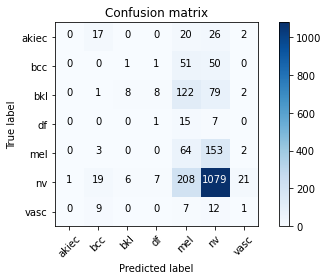

In [10]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

In [12]:
acc = model.evaluate_generator(test_batches, steps=val_steps, verbose=0)

In [13]:
print(acc)

[0.9329421177424613, 0.6679979996849642, 0.8272591089821433, 0.9370943573389539]
